### Домашнее задание по курсу "Методы машинного обучения"
## Студентка ИУ5-23М Костян Алина
### Решение комплексной задачи машинного обучения с учителем.
#### Предсказание суммы трат пользователя, в зависимости от его интересов

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from supervised.automl import AutoML
from sklearn.model_selection import train_test_split
%matplotlib inline 
sns.set(style="ticks")

In [2]:
data = pd.read_csv('telecom_users.csv')

In [3]:
data.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [4]:
data.shape

(5986, 22)

### Пропуски

In [5]:
data_features = list(zip(
# признаки
[i for i in data.columns],
zip(
    # типы колонок
    [str(i) for i in data.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('Unnamed: 0', ('int64', 0)),
 ('customerID', ('object', 0)),
 ('gender', ('object', 0)),
 ('SeniorCitizen', ('int64', 0)),
 ('Partner', ('object', 0)),
 ('Dependents', ('object', 0)),
 ('tenure', ('int64', 0)),
 ('PhoneService', ('object', 0)),
 ('MultipleLines', ('object', 0)),
 ('InternetService', ('object', 0)),
 ('OnlineSecurity', ('object', 0)),
 ('OnlineBackup', ('object', 0)),
 ('DeviceProtection', ('object', 0)),
 ('TechSupport', ('object', 0)),
 ('StreamingTV', ('object', 0)),
 ('StreamingMovies', ('object', 0)),
 ('Contract', ('object', 0)),
 ('PaperlessBilling', ('object', 0)),
 ('PaymentMethod', ('object', 0)),
 ('MonthlyCharges', ('float64', 0)),
 ('TotalCharges', ('object', 0)),
 ('Churn', ('object', 0))]

Пропусков в датасете не обнаружено.

### Кодирование категориальных признаков

In [6]:
data_encoded = data.copy()

In [7]:
columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for column in columns:
    label_encoder = LabelEncoder()
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

In [8]:
data_encoded = data_encoded.drop([data_encoded.columns[0], data_encoded.columns[1], data_encoded.columns[-1], data_encoded.columns[-2]], axis=1)
data_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,1,0,1,1,72,1,2,2,1,1,1,1,1,1,2,0,1,24.10
1,0,0,0,0,44,1,0,1,0,2,2,0,2,0,0,1,1,88.15
2,0,1,1,0,38,1,2,1,0,0,0,0,0,0,0,1,0,74.95
3,1,0,0,0,4,1,0,0,0,0,0,0,0,2,0,1,2,55.90
4,1,0,0,0,2,1,0,0,2,0,2,0,0,0,0,0,2,53.45


In [9]:
x = data_encoded.drop([data_encoded.columns[-1]], axis=1)
x

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,1,0,1,1,72,1,2,2,1,1,1,1,1,1,2,0,1
1,0,0,0,0,44,1,0,1,0,2,2,0,2,0,0,1,1
2,0,1,1,0,38,1,2,1,0,0,0,0,0,0,0,1,0
3,1,0,0,0,4,1,0,0,0,0,0,0,0,2,0,1,2
4,1,0,0,0,2,1,0,0,2,0,2,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,1,0,1,0,1,1,0,1,2,0,0,0,2,2,0,1,2
5982,0,0,1,1,23,1,2,0,2,2,2,2,2,2,2,1,1
5983,1,0,1,1,12,1,0,2,1,1,1,1,1,1,0,1,2
5984,1,1,0,0,12,1,2,1,0,0,2,0,2,2,0,1,2


In [10]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=x.columns)
    return res

In [11]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(x, data_encoded['MonthlyCharges'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape

((4788, 17), (1198, 17), (4788,), (1198,))

In [12]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [13]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [14]:
X_data_dict = {'Basic': (X_train_df, X_test_df)}

In [15]:
def test_models(clas_models_dict, X_train, X_test, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        logger.add(model_name, 'Basic', mse)
            
    return logger

In [16]:
logger = test_models(clas_models_dict, X_train_df, X_test_df, y_train, y_test)

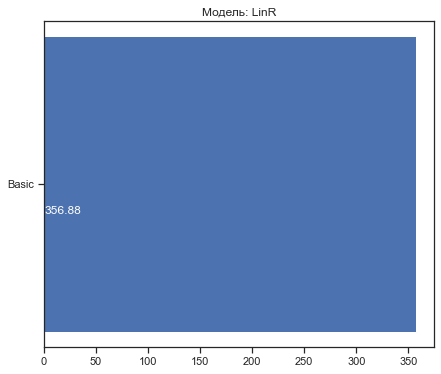

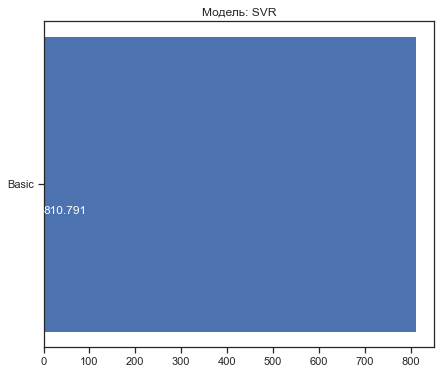

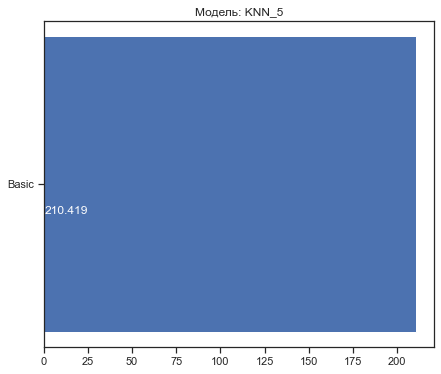

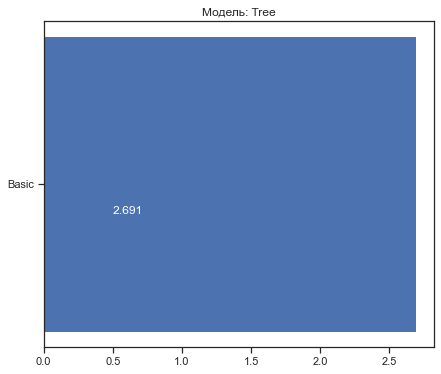

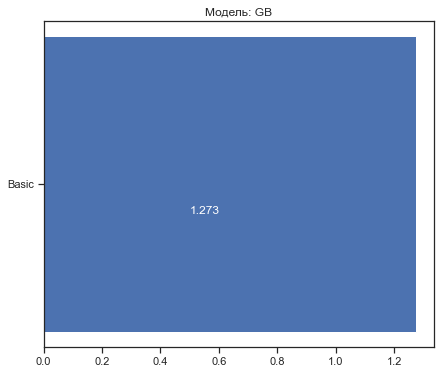

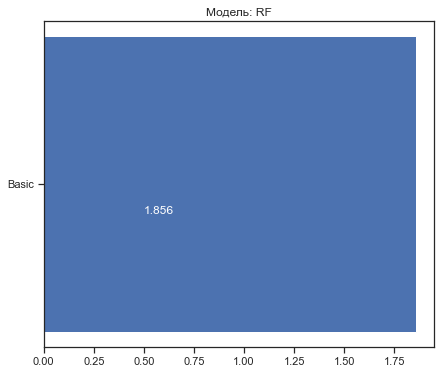

In [17]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

### AutoML

In [18]:
train = data
train.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [19]:
automl = AutoML()

In [20]:
automl.fit(train[train.columns[2:-3]], train['MonthlyCharges'])

AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 30.041484 trained in 0.31 seconds
2_DecisionTree rmse 9.566765 trained in 15.03 seconds
3_Linear rmse 36.208657 trained in 2.7 seconds
* Step default_algorithms will try to check up to 3 models


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


4_Default_Xgboost rmse 1.103866 trained in 5.8 seconds
5_Default_NeuralNetwork rmse 2.882078 trained in 1.22 seconds
6_Default_RandomForest rmse 6.037609 trained in 5.98 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 1.103866 trained in 0.31 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 40.14 seconds
AutoML best model: 4_Default_Xgboost


AutoML()